In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *

2024-07-10 09:12:51.537543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import pandas as pd
import glob
import os 

In [25]:
# Define the folder containing the .txt files
folder_path = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/results_WeightStructureOptim_20240708'

# Initialize a list to store data
data = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # Parse parameters from filename
        params = filename[:-4].split('_')[4:7]
        
        # Read the content of the file into a DataFrame
        file_path = os.path.join(folder_path, filename)
        file_df = pd.read_csv(file_path, delimiter=',')  # Adjust delimiter as needed
        file_df.columns = ['kl_loss_weights', 'mse_loss_structures']  # Adjust column names as needed
        
        params_name = ['num_templates', 'weight_dist', 'noise_std']
        
        # Repeat parameters for each row in the file_df
        for i, param in enumerate(params):
            file_df[params_name[i]] = float(param)
        
        # Append the DataFrame to the list
        data.append(file_df)

# Concatenate all the individual DataFrames into one
final_df = pd.concat(data, ignore_index=True)


In [53]:
final_df

,kl_loss_weights,mse_loss_structures,num_templates,weight_dist,noise_std,kl_loss_nan,kl_loss_inf
0,4.647324e-14,10102.707153,10.0,0.0,40.0,False,False
1,8.049117e-16,10102.707157,10.0,0.0,40.0,False,False
2,1.117162e-15,10102.707160,10.0,0.0,40.0,False,False
3,5.804385e-15,10102.707151,10.0,0.0,40.0,False,False
4,7.806256e-16,10102.707158,10.0,0.0,40.0,False,False
...,...,...,...,...,...,...,...
5863,3.689128e-14,11206.390791,50.0,0.0,20.0,False,False
5864,3.338217e-13,11206.390703,50.0,0.0,20.0,False,False
5865,4.115547e-13,11206.390710,50.0,0.0,20.0,False,False
5866,3.338929e-13,11206.390730,50.0,0.0,20.0,False,False


In [59]:
final_df['kl_loss_nan'] = (final_df.kl_loss_weights.isna()).astype(int)

In [60]:
final_df['kl_loss_inf'] = (np.isinf(final_df.kl_loss_weights)).astype(int)

In [102]:
# calculate kl loss from two random set of numbers 
num_temp = np.arange(1, 501)
kl_loss_array = []
for iter in tqdm(range(1000)):
    kl_loss_list = []
    for i in num_temp:
        random_number_1 = scipy.special.softmax(np.random.rand(i))
        random_number_2 = scipy.special.softmax(np.random.rand(i))
        kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
        kl_loss_list.append(kl_loss)
    kl_loss_array.append(kl_loss_list)

In [97]:
# Generate random polymers with number of templates and calculate frobenius norm
# Try to assign the closest two random polymers to each other
num_temp = [2, 5, 10, 50, 100, 250, 500]
mse_loss_array = []
for iter in tqdm(range(100)):
    mse_loss_list = []
    for i in num_temp:
        rand_polymer_1 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_2 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_1 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_1])
        rand_polymer_2 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_2])
        assigned_polymer_1, assigned_polymer_2 = assign_clusters(rand_polymer_1, rand_polymer_2)
        mse_loss = np.mean([np.linalg.norm(x-y) for x, y in zip(assigned_polymer_1, assigned_polymer_2)])
        mse_loss_list.append(mse_loss)
    mse_loss_array.append(mse_loss_list)

  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
kl_loss_mean = np.mean(kl_loss_array, axis=0)

In [109]:
mse_loss_mean = np.mean(mse_loss_array, axis=0)

In [110]:
mse_loss_mean

array([13313.93371141, 10955.17322508,  9994.21902904,  7694.0612501 ,
        7144.01711943,  6449.02570636,  6067.17709954])

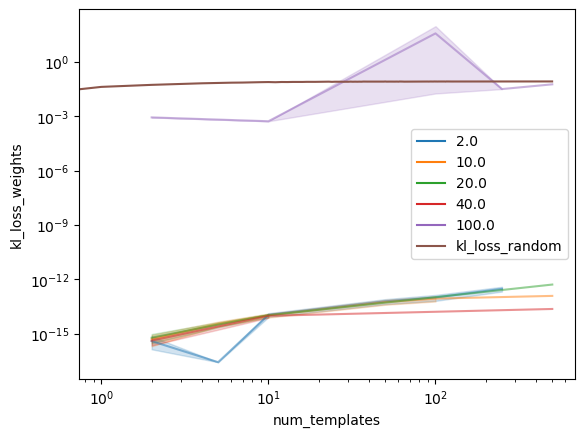

In [105]:
conditions = (final_df['weight_dist'] == 1) 
conditional_df = final_df[conditions]
sns.lineplot(data=conditional_df, x='num_templates', y='kl_loss_weights', hue='noise_std', alpha=0.5, palette='tab10', errorbar='ci', n_boot=5000, seed=10)
plt.plot(kl_loss_mean, label='kl_loss_random')
plt.xscale('log')
plt.yscale('log')
plt.legend()

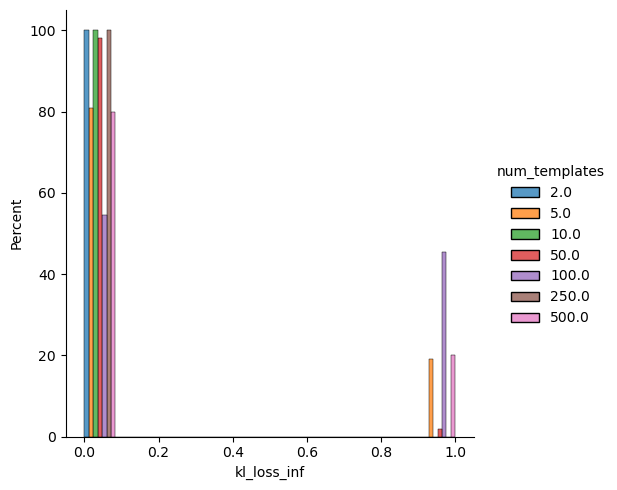

In [71]:
conditions = (final_df['weight_dist'] == 1) 
conditional_df = final_df[conditions]
sns.displot(data=conditional_df, x='kl_loss_inf', hue='num_templates', palette='tab10',kind="hist", multiple='dodge', stat='percent', common_norm=False)

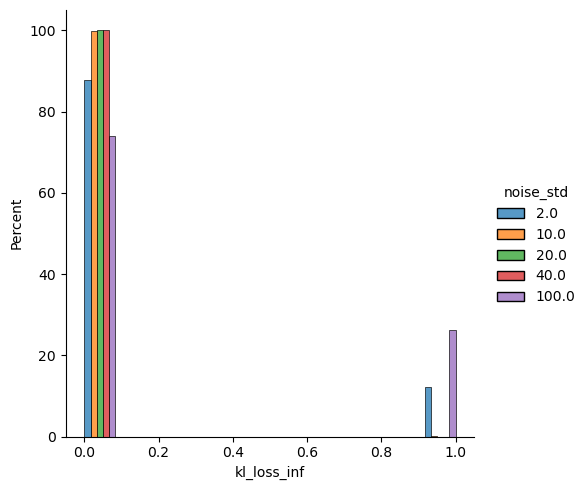

In [74]:
conditions = (final_df['weight_dist'] == 1) 
conditional_df = final_df[conditions]
sns.displot(data=conditional_df, x='kl_loss_inf', hue='noise_std', palette='tab10',kind="hist", multiple='dodge', stat='percent', common_norm=False)

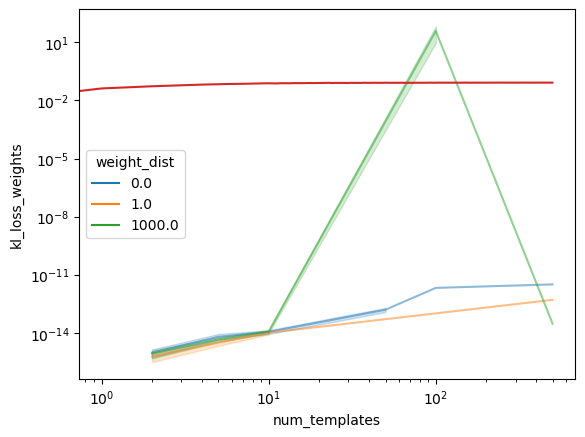

In [106]:
conditions = (final_df['noise_std'] == 20) 
conditional_df = final_df[conditions]
sns.lineplot(data=conditional_df, x='num_templates', y='kl_loss_weights', hue='weight_dist', alpha=0.5, palette='tab10')
plt.plot(kl_loss_mean, label='kl_loss_random')
plt.xscale('log')
plt.yscale('log')


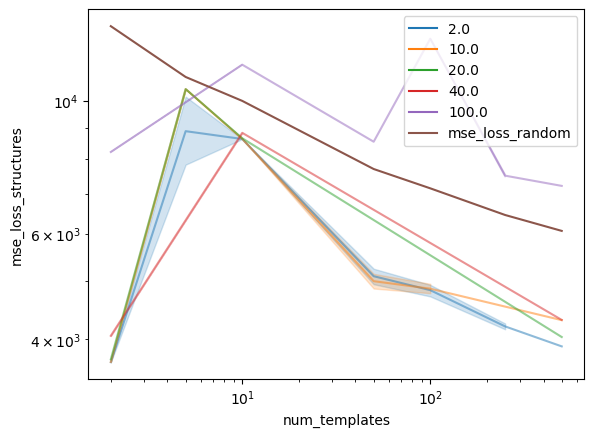

In [112]:
num_temp = [2, 5, 10, 50, 100, 250, 500]
conditions = (final_df['weight_dist'] == 1) 
conditional_df = final_df[conditions]
sns.lineplot(data=conditional_df, x='num_templates', y='mse_loss_structures', hue='noise_std', alpha=0.5, palette='tab10')
plt.plot(num_temp, mse_loss_mean, label='mse_loss_random')
plt.xscale('log')
plt.yscale('log')
plt.legend()


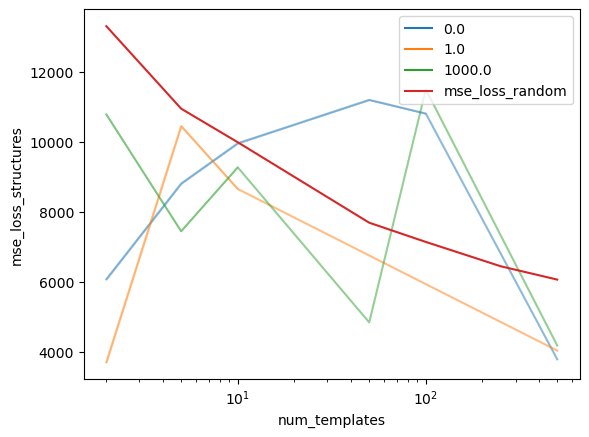

In [101]:
conditions = (final_df['noise_std'] == 20) 
conditional_df = final_df[conditions]
sns.lineplot(data=conditional_df, x='num_templates', y='mse_loss_structures', hue='weight_dist', alpha=0.5, palette='tab10')
plt.plot(num_temp, mse_loss_mean, label='mse_loss_random')
plt.xscale('log')
plt.legend()